## Fashion MNIST Classification with Custom Datasets

In [1]:
import pandas as pd
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchsummary
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# if GPU is available use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The given train and dataset has 785 columns. The first column contains the labels and the rest of 
columns has the pixel values.

In [2]:
image_label = pd.read_csv("data/fashion-mnist_train.csv")
image_label.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create Custom Dataset

In [3]:
class FasionMNISTDataset(Dataset):
    def __init__(self, annotations_file):
        img_labels = pd.read_csv(annotations_file)
        tensors = torch.tensor([img_labels.iloc[i] for i in range(len(img_labels))])
        self.images = tensors[:,1:]
        self.labels = tensors[:,0]
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [4]:
# Datasets
X_train = FasionMNISTDataset("data/fashion-mnist_train.csv")
X_test = FasionMNISTDataset("data/fashion-mnist_test.csv")
# DataLoader
train_dataloader = DataLoader(X_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=64, shuffle=False)

#### Visualize dataset

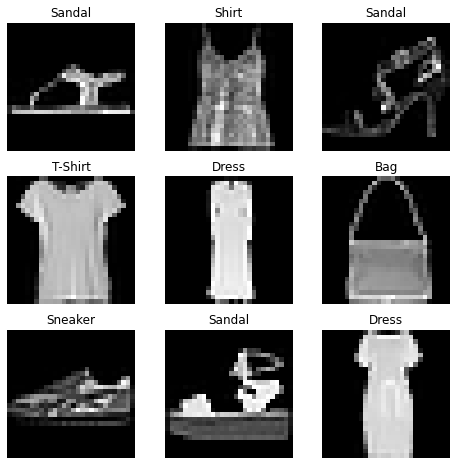

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(X_train), size=(1,)).item()
    img, label = X_train.images[sample_idx], X_train.labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.reshape(28,28), cmap='gray')
plt.show()

#### Define Model

In [32]:
class FashionMNISTClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes):
        super(FashionMNISTClassifier, self).__init__()
        self.batchnorm = nn.BatchNorm1d(784)
        self.linear_layer_1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear_layer_2 = nn.Linear(hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
                
    def forward(self, X):
        out = self.batchnorm(X)
        out = self.linear_layer_1(out)
        out = self.relu(out)
        out = self.linear_layer_2(out)
        out = self.softmax(out)
        return out
    
# Hyperparaters to build model
input_size = 784
hidden_size = 256
num_classes = 10

fashion_mnist_classifier = FashionMNISTClassifier(input_size, hidden_size, num_classes).to(device)

In [33]:
torchsummary.summary(fashion_mnist_classifier,  input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                  [-1, 784]           1,568
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 10]           2,570
           Softmax-5                   [-1, 10]               0
Total params: 205,098
Trainable params: 205,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


In [35]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fashion_mnist_classifier.parameters())

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    n_correct, loss = 0, 0.0
    for images, labels in dataloader:
        images = images.type(torch.FloatTensor)
        images = images.to(device)
        labels = labels.to(device)      
        pred_labels = model(images)
        loss = loss_fn(pred_labels, labels)      
        # Backprpagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        n_correct += (pred_labels.argmax(dim=1) == labels).sum().item()
    accuracy = 100*n_correct/size
    print(f"train_accuracy: {accuracy:>0.1f}%, train_loss: {loss:>8f}") 
    return accuracy, loss
            
def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, n_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.type(torch.FloatTensor)
            images = images.to(device)
            labels = labels.to(device)
            pred_labels = model(images)
            val_loss += loss_fn(pred_labels, labels).item()
            n_correct += (pred_labels.argmax(dim=1) == labels).sum().item()
    val_loss /= num_batches
    val_accuracy = 100*n_correct/size
    print(f"val_accuracy: {val_accuracy:>0.1f}%, val_loss: {val_loss:>8f}")            
    
            
epochs = 30      
for t in range(epochs):
    print(f"Epoch: {t+1}-------------------------------")
    train_loop(train_dataloader, fashion_mnist_classifier, loss_fn, optimizer)
    validation_loop(test_dataloader, fashion_mnist_classifier, loss_fn)
print("Done!")

Epoch: 1-------------------------------
train_accuracy: 86.2%, train_loss: 1.554047
val_accuracy: 86.4%, val_loss: 1.597390
Epoch: 2-------------------------------
train_accuracy: 86.9%, train_loss: 1.587477
val_accuracy: 86.6%, val_loss: 1.594851
Epoch: 3-------------------------------
train_accuracy: 87.3%, train_loss: 1.597330
val_accuracy: 86.3%, val_loss: 1.597001
Epoch: 4-------------------------------
train_accuracy: 87.5%, train_loss: 1.562958
val_accuracy: 87.1%, val_loss: 1.589691
Epoch: 5-------------------------------
train_accuracy: 88.1%, train_loss: 1.523669
val_accuracy: 86.9%, val_loss: 1.591701
Epoch: 6-------------------------------
train_accuracy: 88.0%, train_loss: 1.630868
val_accuracy: 87.2%, val_loss: 1.588289
Epoch: 7-------------------------------
train_accuracy: 88.3%, train_loss: 1.635448
val_accuracy: 86.6%, val_loss: 1.594351
Epoch: 8-------------------------------
train_accuracy: 88.8%, train_loss: 1.668996
val_accuracy: 87.6%, val_loss: 1.585103
Epoch: 9

In [18]:
x = iter(test_dataloader)

In [19]:
img, label = x.next()
print(img.shape)
print(label.shape)

torch.Size([64, 784])
torch.Size([64])


'Pullover'

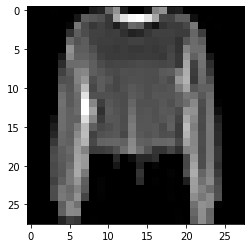

In [27]:
img = img.type(torch.FloatTensor)
plt.imshow(img[50].reshape(28,28), cmap='gray')
labels_map[label[50].item()]

In [24]:
label[0].item()

0